# Starbucks Capstone Challenge

## Project Overview

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, it can be assumed that the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Transactional data is provided showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Also note that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

It is important to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, it is undesirable to send a buy 10 dollars get 2 dollars off offer. 

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement

As stated in the project overview introduction, the task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.  This will be done by determining the top 5 demographic segments for each offer type (buy-one get-one, discount, and informational).  Demographics will be organized based on gender, age segment, and income range segment.

## Metrics

The top 5 segments for each offer type will be based on how much revenue was gained in response to the offer type.

## Data Gathering

First, the relevant Python modules are imported and the json files containing the data are read into pandas dataframes.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration (and Cleaning)
With the data read into the workspace, each dataframe will now go through preliminary exploration and cleaning, starting with the portfolio dataframe.

In [3]:
# Show first rows of the portfolio dataframe
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# Show portfolio dataframe info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


This dataframe is evidently very small, therefore it can be shown in its entirety.

In [5]:
# Show portfolio dataframe
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


THe only obvious cleaning task that should be completed is separating the contents of the channels column.  This is done below.

In [6]:
# Create empty columns to use to expand the contents of the channels column
portfolio['web'] = portfolio.channels.str.contains('web', regex = False)
portfolio['email'] = portfolio.channels.str.contains('email', regex = False)
portfolio['mobile'] = portfolio.channels.str.contains('mobile', regex = False)
portfolio['social'] = portfolio.channels.str.contains('social', regex = False)

# View updated dataframe
portfolio

,channels,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,False,True,True,True
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,True,True,True,True
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,True,True,True,False
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,True,True,True,False
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,True,True,False,False
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,True,True,True,True
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,True,True,True,True
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,False,True,True,True
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,True,True,True,True
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,True,True,True,False


In [7]:
# Drop channels column
portfolio.drop('channels', axis = 1, inplace = True)

# View updated dataframe
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,False,True,True,True
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,True,True,True,True
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,True,True,True,False
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,True,True,True,False
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,True,True,False,False
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,True,True,True,True
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,True,True,True,True
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,False,True,True,True
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,True,True,True,True
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,True,True,True,False


The profile dataframe is now reviewed.

In [8]:
# Show first rows of profile dataframe
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
# Get profile dataframe column statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
# Get profile dataframe info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Based on this cursory exploration, a number of cleaning tasks can be identified:
- Recoding age values of 118 ages to NaN (118 was assigned when the value was missing)
- Convert became_member_on column to datetime datatype
- Remove users with null values for age, gender, income (such entries are not useful in the analysis)

Recoding the age values is completed first, below.

In [11]:
# Replace entries of 118 in the age column with NaN
profile.age.replace(118, np.nan, inplace = True)

# Review first rows of profile dataframe to confirm changes
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
# Review column statistics of updated age column in profile dataframe
profile.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

Next, the became_member_on column is converted to datetime format.  [This](https://stackoverflow.com/questions/27506367/python-pandas-integer-yyyymmdd-to-datetime) Stack Overflow thread was useful in completing this task.

In [13]:
# Convert became_member_on column to datetime format
profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(str), format = '%Y%m%d')

# Review first rows of profile dataframe to confirm changes
profile.head()

,age,became_member_on,gender,id,income
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


Finally, the rows with null values for age, gender, and income columns are removed from the dataframe.

In [14]:
# Drop rows with null values in age, gender, and income columns
profile.dropna(inplace = True)

In [15]:
# Review dataframe info after cleaning
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null float64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 694.9+ KB


The last dataframe to review is the transcript dataframe.  Basic dataframe interrogation is performed below.

In [16]:
# Review first rows of transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
# Get column statistics of transcript dataframe
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [18]:
# Get transcript dataframe info
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
# Samle 10 rows from transcript dataframe
transcript.sample(10)

,event,person,time,value
302776,transaction,d99dec469b3541c497a4a6f7b9be89f7,696,{'amount': 23.3}
264083,offer completed,a94c6c131ec94ba3945d3e906c4b14b8,582,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
296046,transaction,594bea74b95e4cc1b6a2f95550c62b6e,666,{'amount': 2.75}
119472,offer received,4f4e4347594e4f898199f898eebcefd8,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
289716,transaction,102e9454054946fda62242d2e176fdce,648,{'amount': 21.12}
2087,offer received,41f309195094400fa971fe39673b35c7,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
108000,offer completed,5979ee1e3e744c98afd9f72d9be32546,318,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
158605,offer received,3de0f837e72d42799c8e8cdd0f26ea39,408,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
105650,transaction,306f60b7ff784c2eaa236a24498c8507,300,{'amount': 1.49}
232651,transaction,38b88497b30940358be44bd78bdbd071,534,{'amount': 19.46}


Reviewing the transcript dataframe highlights to important cleaning tasks that must be performed:
- Converting the time column from hours to days to be consistent with the portfolio dataframe
- Expanding the contents of the value column

The time column conversion is done first.

In [20]:
# Convert time column from hours to days
transcript.time = transcript.time/24

# Samle 5 rows from transcript dataframe
transcript.sample(5)

,event,person,time,value
284548,offer viewed,a704e150927f49a0ab88f152078f159d,26.25,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
2658,offer received,7d30ff83c4c141d79231d53be5101d9d,0.00,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
38408,transaction,eefff7e6ce0344c2a85ab5dd21db8399,3.50,{'amount': 0.38}
126504,offer viewed,7a26250ec6ff4941a7415e1366b6fb3c,14.00,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
138640,offer viewed,1476bfc85b584e30a79790be39f7929f,15.25,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}


Now, the value column is expanded out.  The expansion will be such that a given entry's dictionary key will be in one new column, and the value will be put into one of two other new columns.  The column the dictionary value goes into depends on whether the dictionary key is an offer id number or a transaction amount.  This work is completed below.

In [21]:
# Extract value column as a list
value_col = list(transcript.value)

# Create lists to store the keys and values of the value column dictionaries
key_list = []
value_list = []

# Loop through the contents of value column
for index in range(len(value_col)):
    
    # Extract dictionary keys
    key = str(value_col[index]).split("'")[1]
    key_list.append(key)
    
    # Extract dictionary values
    value = value_col[index][key]
    value_list.append(value)
    
# Create columns in transcript dataframe to store value column's dictionary keys and values
transcript['value_key'] = key_list
transcript['value_value'] = value_list

# Samle 5 rows from transcript dataframe
transcript.sample(5)

,event,person,time,value,value_key,value_value
156141,offer received,ca93d6bdd8ab4cbba95c072fe17c44e9,17.00,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer id,4d5c57ea9a6940dd891ad53e9dbe8da0
145834,transaction,00e8d701c583461e81cc10053681a12b,16.25,{'amount': 2.16},amount,2.16
24106,offer completed,ea25b858e08a4c8c8d8f299797e38374,1.00,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,offer_id,2298d6c36e964ae4a3e7e9706d1fb8c2
70502,transaction,a53129ef372e44e7af6cbc0a0ec11c26,7.25,{'amount': 26.5},amount,26.5
219635,transaction,d0a80415b84c4df4908b8403b19765e3,21.25,{'amount': 6.5600000000000005},amount,6.56


In [22]:
# View unique values in transcript dataframe value_key column
transcript.value_key.unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

In [23]:
# Replace instances of 'offer id' with 'offer_id' in the value_key column in the transcript dataframe
transcript.value_key = transcript.value_key.str.replace(' ', '_')

# View unique values in transcript dataframe value_key column
transcript.value_key.unique()

array(['offer_id', 'amount'], dtype=object)

In [24]:
# Split value_value column into an offer id column and a transaction amount column
transcript['transaction_amount'] = transcript.loc[transcript.value_key == 'amount'].value_value.astype(float)
transcript['offer_id'] = transcript.loc[transcript.value_key == 'offer_id'].value_value

# View first 5 rows from transcript dataframe
transcript.head()

,event,person,time,value,value_key,value_value,transaction_amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer_id,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
# Drop value, value_key, and value_value columns
transcript.drop(['value', 'value_key', 'value_value'], axis = 1, inplace = True)

# View first 5 rows from transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [32]:
# Get transcript dataframe info
transcript.describe()

,time,transaction_amount
count,306534.000000,138953.000000
mean,15.265956,12.777356
std,8.346930,30.250529
min,0.000000,0.050000
25%,7.750000,2.780000
50%,17.000000,8.890000
75%,22.000000,18.070000
max,29.750000,1062.280000


Now, all dataframes have been explored and cleaned.  This makes it safe to perform some graphical data exploration without worrying that the data is unclean.

## Data Visualization

The data visualization we are interested in focuses on the demographics of Starbucks members, the distribution of entries in the transcipt dataframe, and the distribution of transactions recorded in the transcript dataframe.  Starting with the demographics, the gender of Starbucks members is explored first.

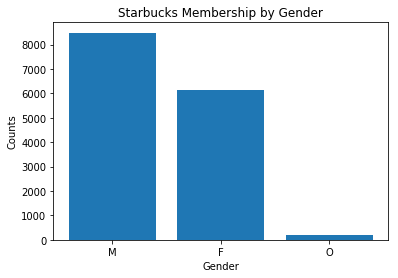

In [26]:
# Create bar chart of membership genders
gender_data = profile.gender.value_counts()
plt.bar(np.arange(len(gender_data)), gender_data.values)
plt.xticks(np.arange(len(gender_data)), gender_data.index)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Starbucks Membership by Gender');

Based on this plot, there are approximately 30% more male members than female members.  There is also a very small contingent of the member base that chose the designation of "other".  Next, a histogram of membership age.

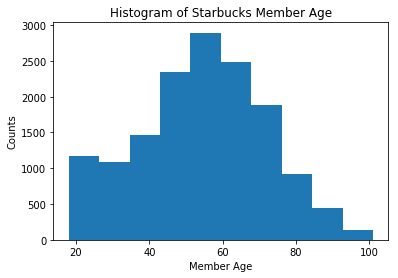

In [27]:
# Histogram of member ages
plt.hist(profile.age)
plt.xlabel('Member Age')
plt.ylabel('Counts')
plt.title('Histogram of Starbucks Member Age');

The age distribution indicates the majority of members are either middle-aged or seniors, although there is a steady membership below the age of 40.  Finally, a histogram of member income is produced.

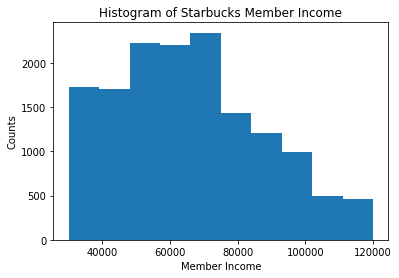

In [28]:
# Histogram of member income
plt.hist(profile.income)
plt.xlabel('Member Income')
plt.ylabel('Counts')
plt.title('Histogram of Starbucks Member Income');

It appears a majority of members of an income of approximately $70,000 or below.  The membership distribution having a higher income steadily declines beyond this threshold.  The next visualization is a bar chart of the different events in the transcript dataframe.

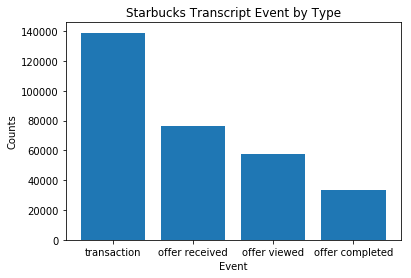

In [29]:
# Create bar chart of events in transcript column
event_data = transcript.event.value_counts()
plt.bar(np.arange(len(event_data)), event_data.values)
plt.xticks(np.arange(len(event_data)), event_data.index)
plt.xlabel('Event')
plt.ylabel('Counts')
plt.title('Starbucks Transcript Event by Type');

A noteable majority of entries are transactions.  It is also worth noting that only about 75% of offers received are viewed, and only approximately half of received offers are completed.  

Finally, a histogram is produced for transaction amount in the transcript dataframe.  From the transaction_amount column statistics in the previous section, there are some outliers in this portion of the data.  Rather than making an assessment of whether these entries are valid, the top percentile of the transaction data will be omitted in this plot instead as a work around.

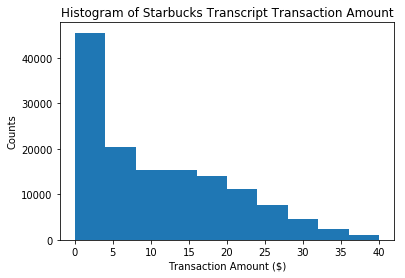

In [33]:
# Histogram of transaction amount
transaction_data = transcript.query('event == "transaction"').transaction_amount
plt.hist(transaction_data, range = (0, transaction_data.quantile(0.99)))
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Counts')
plt.title('Histogram of Starbucks Transcript Transaction Amount');

A large number of transactions are less than 5 dollars, and there is a steady decline in transaction amount count once the transaction exceeds approximately 20 dollars.  With this, the preliminary data exploration is complete and the project moves to the detailed anlaysis.

## Data Preprocessing and Analysis Implementation

The first part of the preprocessing is to create demographic segments for the profile dataframe.  Such segments will make it easier to draw conclusions from the data.

Gender is already categorical, but age and income are not.  For the sake of simplicity, age will grouped by member decade and income will be grouped by 10's of thousands of dollars.  For example, someone aged 34 will be categorized as being in their 30's, and someone making $95,000 will be categorized as having an income in the ninety thousands.

This data processing is completed below.

In [34]:
# Create age demographic based on age decade
profile.loc[profile['age'] < 100, 'decade'] = profile.age.astype(str).str[0] + '0'
profile.loc[profile['age'] >= 100, 'decade'] = profile.age.astype(str).str[0:2] + '0'

# Convert decade column to int datatype
profile.decade = profile.decade.astype(int)

# Review first rows of profile dataframe to confirm changes
profile.head()

,age,became_member_on,gender,id,income,decade
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,60
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,60
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50


In [35]:
# Create income demographic based on 10s of thousands
profile.loc[profile['income'] < 100000, 'income_range'] = (profile.income.astype(str).str[0] + '0000').astype(int)
profile.loc[profile['income'] >= 100000, 'income_range'] = (profile.income.astype(str).str[0:2] + '0000').astype(int)

# Convert income_range column to int datatype
profile.income_range = profile.income_range.astype(int)

# Review first rows of profile dataframe to confirm changes
profile.head()

,age,became_member_on,gender,id,income,decade,income_range
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50,110000
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70,100000
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,60,70000
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,60,50000
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50,50000


The next step is to merge the transcript dataframe with the portfolio dataframe.  This is the first in a series of steps that is required in order to associate an offer type with a transaction.  The merge is performed below.

In [36]:
# Get transcript dataframe info prior to merge
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event                 306534 non-null object
person                306534 non-null object
time                  306534 non-null float64
transaction_amount    138953 non-null float64
offer_id              167581 non-null object
dtypes: float64(2), object(3)
memory usage: 11.7+ MB


In [37]:
# Merge the transcript and portfolio dataframes
transcript = transcript.merge(portfolio, left_on = 'offer_id', right_on = 'id', how = 'outer')

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,True,True,True,False
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,True,True,True,False
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,True,True,True,False
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,True,True,True,False
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,True,True,True,False


In [38]:
# Get transcript dataframe info after merge
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 14 columns):
event                 306534 non-null object
person                306534 non-null object
time                  306534 non-null float64
transaction_amount    138953 non-null float64
offer_id              167581 non-null object
difficulty            167581 non-null float64
duration              167581 non-null float64
id                    167581 non-null object
offer_type            167581 non-null object
reward                167581 non-null float64
web                   167581 non-null object
email                 167581 non-null object
mobile                167581 non-null object
social                167581 non-null object
dtypes: float64(5), object(9)
memory usage: 35.1+ MB


The merge brought over a number of columns that are irrelevant to the final analysis, so these are removed.

In [39]:
# Remove unnecessary columns from updated transcript dataframe
transcript.drop(['id', 'difficulty', 'reward', 'web', 'email', 'mobile', 'social'], axis = 1, inplace = True)

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo


The next step required to associate offer type with transaction is to sort the merged transcript dataframe.  The merge must be sequential: first by customer, then by time, and finally by event.  This sorting sequence is the lynchpin of the dataprocessing, as will be seen in subsequent steps.  The sorting is performed below.

In [40]:
# Sort transcript dataframe based on person, time, and event columns
transcript = transcript.copy().sort_values(['person', 'time', 'event'])

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type
155971,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
157631,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational
205213,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,NaN,NaN,NaN
127775,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational
129199,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational


Now that the dataframe has been sorted, a column will be created that identifies when a received offer will expire.  This column is one of two that will be used to determine if a transaction in the transcript dataframe is of interest in the final analysis.  The column is created below.

In [41]:
# Create an offer expiration column based on the time the offer was received and the offer's duration
transcript.loc[transcript['event'] == 'offer received', 'offer_expiration'] = transcript.time + transcript.duration

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type,offer_expiration
155971,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0
157631,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,NaN
205213,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,NaN,NaN,NaN,NaN
127775,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0
129199,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,NaN


Now, the null values in the offer_id, offer_type, and offer_expiration columns are filled with the previous non-null value.  This is the importance of sorting the dataframe, because an offer, offer type, and offer expiration can be associated with each transaction.  Due to the way the dataframe was cleaned, transaction entries necessarily have null values for each of these columns.  The key assumption made in this step is that a member only has one valid offer they can complete at any given time.  The null values are filled below.

In [42]:
# Forward fill NaN values for offer_id, offer_type and offer_expiration columns
transcript.offer_id.fillna(method = 'ffill', inplace = True)
transcript.offer_type.fillna(method = 'ffill', inplace = True)
transcript.offer_expiration.fillna(method = 'ffill', inplace = True)

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type,offer_expiration
155971,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0
157631,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0
205213,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,5a8bc65990b245e5a138643cd4eb9837,NaN,informational,10.0
127775,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0
129199,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0


Filling these null values allows a column to be created that determines how much time is left for the active offer for the given dataframe entry.  This column is created below.

In [43]:
# Create column that determines how much remaining time an offer is valid for
transcript['offer_time_left'] = transcript.offer_expiration - transcript.time

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type,offer_expiration,offer_time_left
155971,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0,3.0
157631,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0,2.0
205213,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,5a8bc65990b245e5a138643cd4eb9837,NaN,informational,10.0,0.5
127775,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0,4.0
129199,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0,2.5


The penultimate step is to add a column that denotes whether an offer has been viewed, a requirement for including a given transaction in the analysis.  This is done in boolean, where a True value is assigned to dataframe entries of "offer viewed", and a False value is assigned to dataframe entries of "offer received".  Then, null entries are forward filled.  Including the False values for "offer received" entries acts as a reset for each new offer.  This column is created below.

In [44]:
# Create column that determines whether a transaction is based on viewing an offer
transcript.loc[transcript['event'] == 'offer viewed', 'ov_transaction'] = True
transcript.loc[transcript['event'] == 'offer received', 'ov_transaction'] = False

# Forward fill null values in the ov_transaction column to associate transactions with viewing offers
transcript.ov_transaction.fillna(method = 'ffill', inplace = True)

# View first rows of transcript dataframe
transcript.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type,offer_expiration,offer_time_left,ov_transaction
155971,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0,3.0,False
157631,offer viewed,0009655768c64bdeb2e877511632db8f,8.0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,informational,10.0,2.0,True
205213,transaction,0009655768c64bdeb2e877511632db8f,9.5,22.16,5a8bc65990b245e5a138643cd4eb9837,NaN,informational,10.0,0.5,True
127775,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0,4.0,False
129199,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,3f207df678b143eea3cee63160fa8bed,4.0,informational,18.0,2.5,True


With this last step completed, it is now possible to isolate the transactions of interest from the transcript dataframe.  As a reminder, such transactions are those which were motivated by an offer and which occurred within the offer window.  Using this definition, the transcript dataframe is filtered and the filtered entries are stored into a new dataframe for the analysis.  This is done below.

In [45]:
# Create dataframe of transactions targeted by the analysis
offer_transactions = transcript.copy().query('event == "transaction"').query('offer_time_left >= 0').query('ov_transaction')

# View first rows of target transactions dataframe
offer_transactions.head()

,event,person,time,transaction_amount,offer_id,duration,offer_type,offer_expiration,offer_time_left,ov_transaction
205213,transaction,0009655768c64bdeb2e877511632db8f,9.50,22.16,5a8bc65990b245e5a138643cd4eb9837,NaN,informational,10.0,0.50,True
270873,transaction,0009655768c64bdeb2e877511632db8f,23.00,13.56,fafdcd668e3743c1bb461111dcafc2a4,NaN,discount,31.0,8.00,True
209865,transaction,0011e0d4e6b944f998e987f904e8c1e5,10.50,11.93,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,discount,14.0,3.50,True
276373,transaction,0011e0d4e6b944f998e987f904e8c1e5,24.00,22.05,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,28.0,4.00,True
292013,transaction,0011e0d4e6b944f998e987f904e8c1e5,26.75,23.03,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,28.0,1.25,True


Filtering the dataframe means that now there are several unnecessary columns.  These are removed below.

In [46]:
# Drop unnecessary columns from offer_transactions dataframe
offer_transactions.drop(['event', 'time', 'duration', 'offer_expiration', 'offer_time_left', 'ov_transaction'], 
                        axis = 1, inplace = True)

# View first rows of target transactions dataframe
offer_transactions.head()

,person,transaction_amount,offer_id,offer_type
205213,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,informational
270873,0009655768c64bdeb2e877511632db8f,13.56,fafdcd668e3743c1bb461111dcafc2a4,discount
209865,0011e0d4e6b944f998e987f904e8c1e5,11.93,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
276373,0011e0d4e6b944f998e987f904e8c1e5,22.05,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
292013,0011e0d4e6b944f998e987f904e8c1e5,23.03,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount


With that last bit of touch up complete, it is now possible to at least see the amount of revenue each offer type was able to generate.  This is done with the bar chart below.

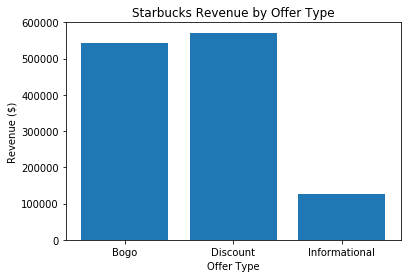

In [47]:
# Make bar chart of amount spent per offer type
revenue_data = offer_transactions.copy().groupby('offer_type').sum()
plt.bar(np.arange(len(revenue_data)), revenue_data.transaction_amount)
plt.xticks(np.arange(len(revenue_data)), [cat.title() for cat in revenue_data.index])
plt.xlabel('Offer Type')
plt.ylabel('Revenue ($)')
plt.title('Starbucks Revenue by Offer Type');

It can be seen that buy-one get-one and discount offer types generate roughly the same revenue in this dataset, while informational offers generate much less.  It may be that some cost-benefit analysis is required for the informational offers  While these offers don't cost anything at the cash register, the overhead in developing the promotion does have expenses.

Moving on, the profile dataframe is merged with this newly created offer_transactions dataframe so that demographic data can be associated with the transaction type.  This is done below.

In [48]:
# Get offer_transactions dataframe info prior to merge
offer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96083 entries, 205213 to 293172
Data columns (total 4 columns):
person                96083 non-null object
transaction_amount    96083 non-null float64
offer_id              96083 non-null object
offer_type            96083 non-null object
dtypes: float64(1), object(3)
memory usage: 3.7+ MB


In [49]:
# Merge the offer_transactions and profile dataframes
offer_transactions = offer_transactions.merge(profile, left_on = 'person', right_on = 'id', how = 'left')

# View first rows of offer_transactions dataframe
offer_transactions.head()

,person,transaction_amount,offer_id,offer_type,age,became_member_on,gender,id,income,decade,income_range
0,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,33.0,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,30.0,70000.0
1,0009655768c64bdeb2e877511632db8f,13.56,fafdcd668e3743c1bb461111dcafc2a4,discount,33.0,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,30.0,70000.0
2,0011e0d4e6b944f998e987f904e8c1e5,11.93,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,40.0,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,40.0,50000.0
3,0011e0d4e6b944f998e987f904e8c1e5,22.05,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,40.0,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,40.0,50000.0
4,0011e0d4e6b944f998e987f904e8c1e5,23.03,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,40.0,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,40.0,50000.0


In [50]:
# Get offer_transactions dataframe info after merge
offer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96083 entries, 0 to 96082
Data columns (total 11 columns):
person                96083 non-null object
transaction_amount    96083 non-null float64
offer_id              96083 non-null object
offer_type            96083 non-null object
age                   85611 non-null float64
became_member_on      85611 non-null datetime64[ns]
gender                85611 non-null object
id                    85611 non-null object
income                85611 non-null float64
decade                85611 non-null float64
income_range          85611 non-null float64
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 8.8+ MB


As before, some of the columns brought over by the merge will not be used in the final analysis, and so they are dropped.

In [51]:
# Remove unnecessary columns from offer_transactions dataframe
offer_transactions.drop(['age', 'became_member_on', 'id', 'income'], axis = 1, inplace = True)

# View first rows of offer_transactions dataframe
offer_transactions.head()

,person,transaction_amount,offer_id,offer_type,gender,decade,income_range
0,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,informational,M,30.0,70000.0
1,0009655768c64bdeb2e877511632db8f,13.56,fafdcd668e3743c1bb461111dcafc2a4,discount,M,30.0,70000.0
2,0011e0d4e6b944f998e987f904e8c1e5,11.93,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,O,40.0,50000.0
3,0011e0d4e6b944f998e987f904e8c1e5,22.05,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,O,40.0,50000.0
4,0011e0d4e6b944f998e987f904e8c1e5,23.03,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,O,40.0,50000.0


Another consequence of the merge is that a little over 10% of the transaction entries have null values for the demographic columns.  These rows are dropped, since demographic association with transaction_amount is required for the analysis.  This is done below.

In [52]:
# Drop rows containing null entries for any of the demographic columns
offer_transactions.dropna(inplace = True)

# View info for offer_transactions dataframe
offer_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85611 entries, 0 to 96082
Data columns (total 7 columns):
person                85611 non-null object
transaction_amount    85611 non-null float64
offer_id              85611 non-null object
offer_type            85611 non-null object
gender                85611 non-null object
decade                85611 non-null float64
income_range          85611 non-null float64
dtypes: float64(3), object(4)
memory usage: 5.2+ MB


Finally, the transaction amounts are aggregated by demographic and stored in a dataframe.  This is where all of the pre-processing comes together to produce a nearly finished result.

In [53]:
# Create lists to store demographic values
offer_values = []
gender_values = []
decade_values = []
income_range_values = []
transaction_sum_values = []

# Create dictionary structure to store demographic data
demographic_dict = {'offer_type': offer_values,
                   'gender': gender_values,
                   'decade': decade_values,
                   'income_range': income_range_values,
                   'transaction_sum': transaction_sum_values}

# Loop through demographic categories to determine how much each group spent based on gender and age
for offer_type in offer_transactions.offer_type.unique():
    
    # Subset offer_transactions based on offer type
    offer_subset = offer_transactions.query('offer_type == @offer_type')
    
    for gender in offer_transactions.gender.unique():
        
        # Further subset offer_transactions based on gender
        gender_subset = offer_subset.query('gender == @gender')
        
        for decade in offer_transactions.decade.unique():
            
            # Further subset offer_transactions based on decade
            decade_subset = gender_subset.query('decade == @decade')
            
            for income_range in offer_transactions.income_range.unique():
                
                # Finish subset of offer_transactions, based on income_range
                income_range_subset = decade_subset.query('income_range == @income_range')
                
                # Get amount spent for given demographic
                transaction_sum = income_range_subset.transaction_amount.sum()
                
                # Append demographic data to lists
                offer_values.append(offer_type)
                gender_values.append(gender)
                decade_values.append(decade)
                income_range_values.append(income_range)
                transaction_sum_values.append(transaction_sum)        

In [54]:
# Create dataframe for demographic data
demographics = pd.DataFrame(demographic_dict)

# View first rows of demographics dataframe
demographics.head()

,offer_type,gender,decade,income_range,transaction_sum
0,informational,M,30.0,70000.0,705.86
1,informational,M,30.0,50000.0,1119.37
2,informational,M,30.0,90000.0,202.64
3,informational,M,30.0,60000.0,1447.89
4,informational,M,30.0,40000.0,888.96


In [55]:
# View demographics dataframe info
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
offer_type         900 non-null object
gender             900 non-null object
decade             900 non-null float64
income_range       900 non-null float64
transaction_sum    900 non-null float64
dtypes: float64(3), object(2)
memory usage: 35.2+ KB


The new demographics dataframe has but one cleaning task, which is to convert the decade and income_range column from float to int datatype.  This is done mainly for the sake of the plots that will be produced in the next steps.  The datatype change is performed below.

In [56]:
# Convert decade and income_range columns from float to int datatype
demographics[['decade', 'income_range']] = demographics[['decade', 'income_range']].astype(int)

# View demographics dataframe info
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
offer_type         900 non-null object
gender             900 non-null object
decade             900 non-null int64
income_range       900 non-null int64
transaction_sum    900 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 35.2+ KB


With that minor cleaning complete, a discussion of the results can be pursued.

## Results

Fist, some graphical exploration is in order to understand some basic relationships between demographic and transaction amount.  First, a barplot of gender vs transaction amount is produced.

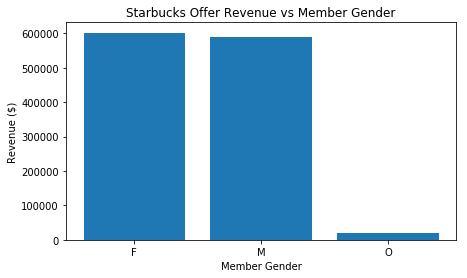

In [57]:
# Plot transaction_sum by gender
gender_data = demographics.groupby('gender').sum()
plt.figure(figsize = (7,4))
plt.bar(np.arange(len(gender_data)), gender_data.transaction_sum)
plt.xticks(np.arange(len(gender_data)), [index.title() for index in gender_data.index])
plt.xlabel('Member Gender')
plt.ylabel('Revenue ($)')
plt.title('Starbucks Offer Revenue vs Member Gender');

Interestingly, female members are spending more in response to Starbucks' offers than male members, despite there being roughly 30% more male members than female members.  

Next, age versus transaction amount is explored.

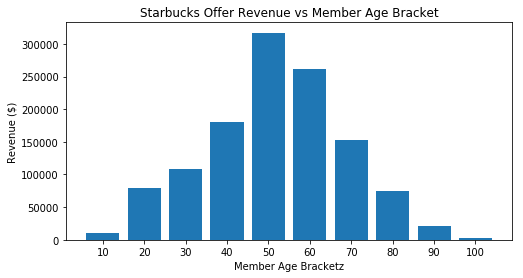

In [58]:
# Plot transaction_sum by decade
decade_data = demographics.groupby('decade').sum()
plt.figure(figsize = (8,4))
plt.bar(np.arange(len(decade_data)), decade_data.transaction_sum)
plt.xticks(np.arange(len(decade_data)), [index for index in decade_data.index])
plt.xlabel('Member Age Bracketz')
plt.ylabel('Revenue ($)')
plt.title('Starbucks Offer Revenue vs Member Age Bracket');

From this plot, it is evient that the majority of revenue gained in response to offers is earned from members who are either middle-aged or you seniors.

Last, the role of income range with respect to transaction amount is reviewed with a final bar plot.

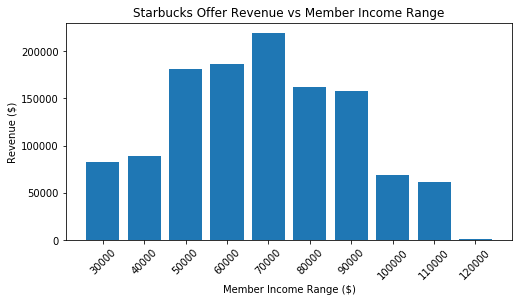

In [59]:
# Plot transaction_sum by income_range
income_range_data = demographics.groupby('income_range').sum()
plt.figure(figsize = (8,4))
plt.bar(np.arange(len(income_range_data)), income_range_data.transaction_sum)
plt.xticks(np.arange(len(income_range_data)), [index for index in income_range_data.index], rotation = 45)
plt.xlabel('Member Income Range ($)')
plt.ylabel('Revenue ($)')
plt.title('Starbucks Offer Revenue vs Member Income Range');

This plot indicates that the majority of revenue gained in response to a Starbucks offer is earned from members with an income of between 50,000 and 100,000 dollars.  That is a pretty broad range of incomes, so this finding may not be as beneficial as the other two findings.

The last step is to compile the top five spending demographics for each offer type into a single dataframe.  This is done below.

In [60]:
# Get top 5 most valuable demographics for each offer type
bogo_top_5 = demographics.copy().query('offer_type == "bogo"').sort_values('transaction_sum', ascending = False).head()
discount_top_5 = demographics.copy().query('offer_type == "discount"').sort_values('transaction_sum', ascending = False).head()
info_top_5 = demographics.copy().query('offer_type == "informational"').sort_values('transaction_sum', ascending = False).head()

# Combine top 5 most valuable for each offer type into a single dataframe
best_demographics = bogo_top_5.append(discount_top_5.append(info_top_5))
best_demographics = best_demographics.set_index('offer_type')

# Add column that shows demographic rank in offer type
best_demographics['offer_type_rank'] = list(np.arange(1,6))*3

# View dataframe containing top 5 demographics for each offer type
best_demographics

,gender,decade,income_range,transaction_sum,offer_type_rank
offer_type,,,,,
bogo,F,50,80000,14056.96,1
bogo,F,50,70000,13197.63,2
bogo,M,50,70000,12937.15,3
bogo,F,60,70000,11921.69,4
bogo,F,50,90000,11286.60,5
discount,F,50,70000,15520.88,1
discount,F,60,70000,14672.27,2
discount,M,50,70000,13715.99,3
discount,F,60,80000,13495.43,4


As can be seen from the top five results, the majority of the best responding demographics are women who are middle-aged or early seniors, with an income of 70,000 - 80,000 dollars.  This is consistent with the plots produced just above.  

One new finding from this tabulation, however, is that middle-aged men with an income similar to just describe are responding better to informational offers than other demographics.

## Conclusion

In this analysis, data from Starbucks was used to associate revenue earned in response to a Starbucks promotional offer with the offer type.  This was done first associating Starbucks' offer type with transaction amounts, and then determining if the transactions were motivated by the Starbucks offer and performed while the offer was active.  Once these target transactions were identified, the Starbucks membership information was divided into demographic segments and combined with the target transaction data.  With this combined dataset, transaction sums were calculated for each demographic group.

Out of all of the activity performed, the most difficult was programatically identifying which transactions were motivated by a the Starbucks offer.  Without the pandas dataframe sorting and filling commands, a solution to this task would have been very challenging to conceive.  Even conceiving the solution with these pandas capabilities took some extended brainstorming.

There is some room for improvement with this project, depending on what the Starbucks marketing team wants to achieve.  The demographic category definitions for age and income range are likely inconsistent with what Starbucks uses internally.  Additionally, no care was given to the source of the offer (web, social, etc.) or the revenue lost from honoring the discount and buy-one get-one offers.  Including those aspects would be recommended next steps.